Authors:
Goto, Ipei B.
Quinto, Christopher A.
Talato, Joshua P.

Acronyms : 
- THI = Total Household Income

Objective: 
1. Explore the data set.
    - See which attributes are continuous / categorial.
        - Visually represent them.
    - Identify which attributes of a household has a relationship with THI.
        - Correctly identify if attributes that has correlations with THI are solely region based or nationwide.

3. Visualize the relationship in a graphical manner

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
df = pd.read_csv("Family Income and Expenditure.csv")

Measuring the data

- There are 41,544 rows. with 60 columns!

In [5]:
df.shape

(41544, 60)

Data types Categorical or Continous


In [6]:
print(df.dtypes)

Total Household Income                            int64
Region                                           object
Total Food Expenditure                            int64
Main Source of Income                            object
Agricultural Household indicator                  int64
Bread and Cereals Expenditure                     int64
Total Rice Expenditure                            int64
Meat Expenditure                                  int64
Total Fish and  marine products Expenditure       int64
Fruit Expenditure                                 int64
Vegetables Expenditure                            int64
Restaurant and hotels Expenditure                 int64
Alcoholic Beverages Expenditure                   int64
Tobacco Expenditure                               int64
Clothing, Footwear and Other Wear Expenditure     int64
Housing and water Expenditure                     int64
Imputed House Rental Value                        int64
Medical Care Expenditure                        

Only pick the int64, i.e the continous variable types.

Create a correlation matrix.

See which ones correlate the most with Total Household Icome

> note that this is for all regions of the Philippines. this is going to be a breath first analysis.

<Axes: >

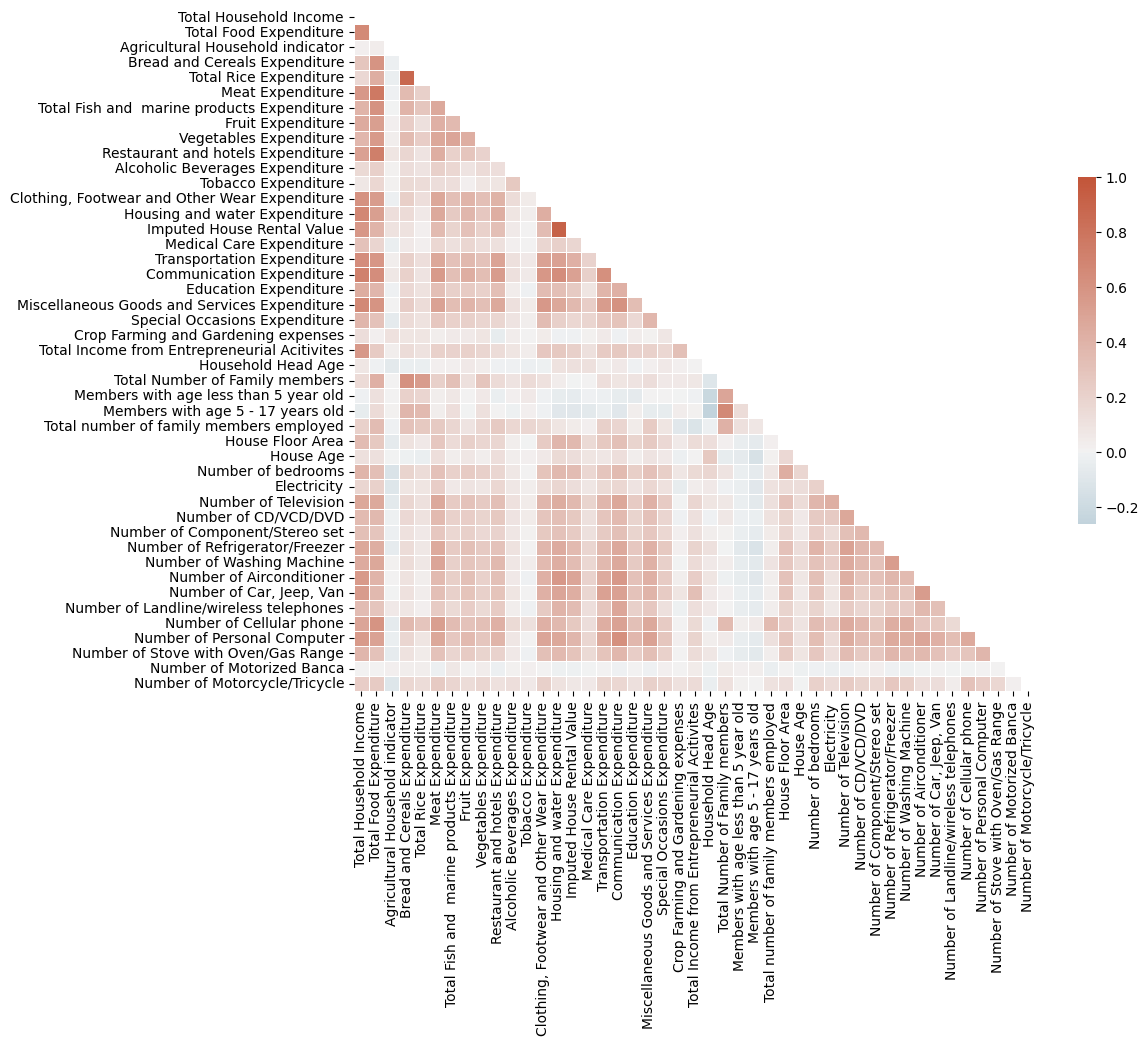

In [24]:
#this code only picks out the columns that is integer type, i.e continous datatype.
continous_df = df.loc[:, df.dtypes == np.int64]

corr = continous_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})



Printing out the specific values

In [20]:
print(corr['Total Household Income'].sort_values(ascending=False))

Total Household Income                           1.000000
Communication Expenditure                        0.710140
Housing and water Expenditure                    0.676186
Miscellaneous Goods and Services Expenditure     0.666288
Total Food Expenditure                           0.663660
Transportation Expenditure                       0.639939
Clothing, Footwear and Other Wear Expenditure    0.605992
Imputed House Rental Value                       0.574091
Meat Expenditure                                 0.567142
Total Income from Entrepreneurial Acitivites     0.563662
Number of Personal Computer                      0.557561
Number of Airconditioner                         0.551994
Number of Car, Jeep, Van                         0.546663
Restaurant and hotels Expenditure                0.510017
Number of Cellular phone                         0.488106
Number of Television                             0.475170
Number of Refrigerator/Freezer                   0.473454
Fruit Expendit

#### From highest to lowest, the expenditures that have a significant correlation with Total Household Income are:
1. Communication Expenditure                        0.710140
2. Housing and water Expenditure                    0.676186
3. Miscellaneous Goods and Services Expenditure     0.666288
4. Total Food Expenditure                           0.663660
5. Transportation Expenditure                       0.639939
6. Clothing, Footwear and Other Wear Expenditure    0.605992
7. Meat Expenditure                                 0.567142
8. Restaurant and hotels Expenditure                0.510017

#### Low Exducation Expenditure Correlation
>  A surprising observation is that Education doesn't have a strong correlation (a value equal greater than 0.45) to Total Household Income.
#### Meaning that Education expenses isn't an indicator for total household income for the Philippines as a whole 
> Why is that?  
>> Possible reasons  
>> 1. Public Education Systems reduces out of pocket expenses  
>> 2. Education is not as important as other type of expenses, so it gets left behind.  
>>> - Let's see if this holds true if we look at the regions individually.

### Now let's explore the following
#### 1. Regression analysis to validate these correlations
#### 2. Non-linear relationship possibilities
#### 3. Potential regional variations in these correlations




In [ ]:
# Regression analysis

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare your features and target
#Columns to be dropped
dropped_columns = ['Total Number of Family members',
                   'Members with age less than 5 year old',
                   'Members with age 5 - 17 years old',
                   'Total number of family members employed'
                   'House Floor Area', 
                   'House Age',
                   'Number of bedrooms',
                   'Electricity',
                   'Number of Television',
                   'Number of CD/VCD/DVD',
                   'Number of Component/Stereo set',
                   'Number of Refrigerator/Freezer',
                   'Number of Washing Machine',
                   'Number of Airconditioner',
                   'Number of Car, Jeep, Van',
                   'Number of Landline/wireless telephones',
                   'Number of Cellular phone',
                   'Number of Personal Computer',
                   'Number of Stove with Oven/Gas Range',
                   'Number of Motorized Banca',
                   'Number of Motorcycle/Tricycle']
X = continous_df.drop(columns=dropped_columns, axis=1)
y = continous_df['Total Household Income']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fit linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr_model.predict(X_test)
print("Linear Regression R-squared:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

# Check feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(lr_model.coef_)
})
print(feature_importance.sort_values('importance', ascending=False))

KeyError: "['Total number of family members employedHouse Floor Area'] not found in axis"

In [27]:
#Non Linear Analysis

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Polynomial Regression (2nd degree)
poly_reg = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred_poly = poly_reg.predict(X_test)
print("Polynomial Regression R-squared:", r2_score(y_test, y_pred_poly))

Polynomial Regression R-squared: 0.5776292321286131


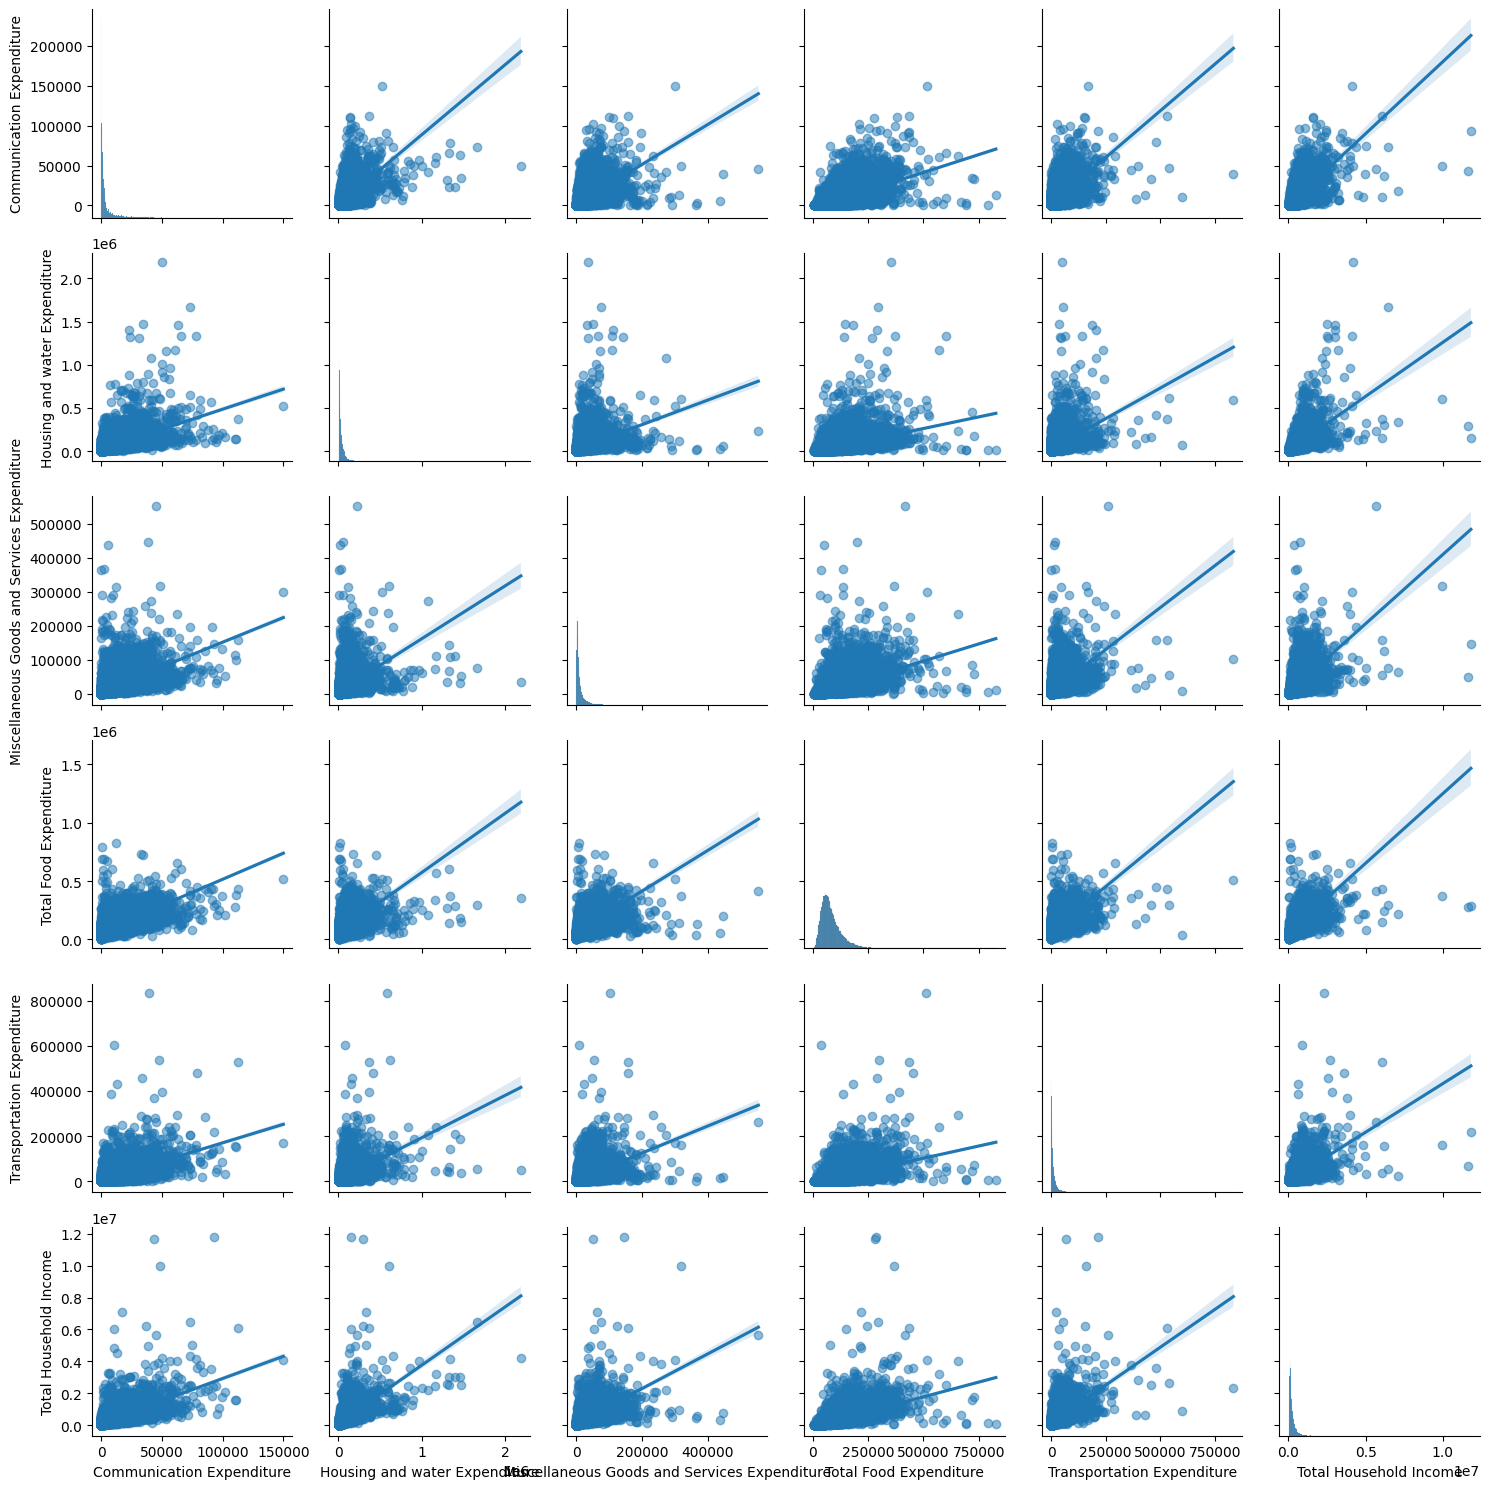

In [29]:

# Pairplot to visualize non-linear relationships
top_correlated_features = corr['Total Household Income'].sort_values(
    ascending=False)[1:6].index.tolist()
sns.pairplot(continous_df[top_correlated_features + ['Total Household Income']],
             kind='reg',
             plot_kws={'scatter_kws': {'alpha': 0.5}})
plt.tight_layout()
plt.show()

Group By Region:
- See the median Total Food Expenditure
- See the median Total Household Income

In [7]:
df_regions = df.groupby('Region')
Median_MHI_aggregated_df_regions = df_regions.agg(
    Median_Household_Income=('Total Household Income', 'median')
)
Median_MHI_aggregated_df_regions


,Median_Household_Income
Region,
ARMM,111394.0
CAR,188580.0
Caraga,132282.5
I - Ilocos Region,172109.5
II - Cagayan Valley,167560.0
III - Central Luzon,220208.0
IVA - CALABARZON,227757.0
IVB - MIMAROPA,140483.0
IX - Zasmboanga Peninsula,126567.0


In [8]:
Median_TFE_aggregated_df_regions = df_regions.agg(
    Median_Household_Expenditure=('Total Food Expenditure', 'median')
)
#Median_TFE_aggregated_df_regions.rank(ascending=False)
Median_TFE_aggregated_df_regions

,Median_Household_Expenditure
Region,
ARMM,60550.0
CAR,73578.0
Caraga,63514.0
I - Ilocos Region,71974.5
II - Cagayan Valley,68237.0
III - Central Luzon,89919.0
IVA - CALABARZON,94760.0
IVB - MIMAROPA,62590.0
IX - Zasmboanga Peninsula,59256.0
